# EEG Data interpretation -  Meditation and Alpha/Theta Ratio Analysis

## 1. Import Libraries and Setup


In [34]:
import mne
import pandas as pd
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# inline plotting
%matplotlib inline

# get the directory where this notebook is located
script_dir = Path.cwd()

# this removes MNE info/warning messages from the output
# change to "INFO" for more output verbosity
mne.set_log_level("WARNING")

## 2. Load EEG Data


Datasets are later accessed in the file based on their *raws* index.

In [42]:
raw_classical_1 = mne.io.read_raw_brainvision(
        script_dir / "data/classical_A_M_2025-12-15_15-04-18.vhdr",
        preload=True,
    )

raw_classical_2 = mne.io.read_raw_brainvision(
        script_dir / "data/classical_A_S_2025-12-18_10-40-05.vhdr",
        preload=True,
    )

raw_classical_3 = mne.io.read_raw_brainvision(
        script_dir / "data/classical_S_HA_2025-12-18_14-05-33.vhdr",
        preload=True,
    )

raw_rock_1 = mne.io.read_raw_brainvision(
        script_dir / "data/rock_B_A_2025-12-18_15-13-43.vhdr",
        preload=True,
    )

raw_rock_2 = mne.io.read_raw_brainvision(
        script_dir / "data/rock_S_H_2025-12-18_11-57-47.vhdr",
        preload=True,
    )

raw_rock_3 = mne.io.read_raw_brainvision(
        script_dir / "data/rock_S_M_2025-12-15_16-11-41.vhdr",
        preload=True,
    )

raws = [
    raw_classical_1,
    raw_classical_2,
    raw_classical_3,
    raw_rock_1,
    raw_rock_2,
    raw_rock_3,
]

C:\Users\bicle\AppData\Local\Temp\ipykernel_20628\4283246520.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_classical_1 = mne.io.read_raw_brainvision(
C:\Users\bicle\AppData\Local\Temp\ipykernel_20628\4283246520.py:6: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_classical_2 = mne.io.read_raw_brainvision(
C:\Users\bicle\AppData\Local\Temp\ipykernel_20628\4283246520.py:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_classical_3 = mne.io.read_raw_brainvision(
C:\Users\bicle\AppData\Local\Temp\ipykernel_20628\4283246520.py:16: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_rock_1 = mne.io.read_raw_brainvision(
C:\Users\bicle\AppData\Local\Temp\ipykernel_20628\4283246520.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_rock_2 = mne.io.read_raw_brainvision(
C:\User

In [43]:
# 'standard_1020' - standard 10-20 system positions
montage = mne.channels.make_standard_montage('standard_1020')

for raw in raws:
    raw.set_montage(montage, match_case=False, on_missing="ignore")

## 3. Visualize Raw Data (OPTIONAL)


*IMPORTANT*

- Set `visualize_raw_data` to True or False.
- Set `raw_to_view` to the correct raws index.

EXAMPLE: `raw_to_view = raw_classical_1` *or* `raw_to_view = raws[0]` (first raw component)


In [ ]:
visualize_raw_data = False # True or False
raw_to_view = raws[0] # raw file name/index

Show plot of raw data/ openes MNE.

In [48]:
if visualize_raw_data:
    raw_to_view.plot(
        duration=10.0,
        n_channels=22,
        scalings="auto",
        title="Classical Music - Raw Data",
        show=True
    )
    plt.show()

Power spectral density of raw data

In [49]:
if visualize_raw_data:
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    psd = raw.compute_psd(fmax=100)
    psd.plot(axes=ax, show=False)

    ax.set_title("Raw Data - Power Spectral Density")
    plt.show()

## 4. Preprocessing Pipeline


### 4.1 Filtering

Apply notch filters (remove line noise)

In [73]:
# copy for preprocessing
raws_filtered = [raw.copy() for raw in raws]

# 50 & 100 Hz notch filters
for raw in raws_filtered:
    raw.notch_filter([50, 100])

Bandpass filtering (1-40 Hz)


In [52]:
for raw in raws_filtered:
    raw.filter(l_freq=1, h_freq=40)

### 4.2 PSD Visualization (OPTIONAL)

*IMPORTANT*

- Set `visualize_psd_comparison` to True or False.
- Set `raw_to_view` to the correct raws index.

EXAMPLE: `raw_to_view = raw_classical_1` *or* `raw_to_view = raws[0]`

In [69]:
visualize_psd_comparison =  False # True or False
raw_to_view = raws[1] # raw file name/index

PSD before and after filtering

In [71]:
if visualize_psd_comparison:
    # select raw and filtered data
    raw_before = raw_to_view
    raw_after = raws_filtered[raws.index(raw_to_view)]

    # create figure
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # PSD before filtering
    psd_before = raw_before.compute_psd(fmax=100)
    psd_before.plot(axes=axes[0], show=False)
    axes[0].set_title("Data PSD before Filtering")

    # PSD after filtering
    psd_after = raw_after.compute_psd(fmax=100)
    psd_after.plot(axes=axes[1], show=False)
    axes[1].set_title("Data PSD after Filtering")

    plt.show()


Zoomed-in PSD filtered EEG for Alpha and Theta freq

In [72]:
if visualize_psd_comparison:
    # select filtered raw data
    raw_after = raws_filtered[raws.index(raw_to_view)]

    # focused PSD theta alpha only
    fig, ax = plt.subplots(figsize=(12, 8))

    psd_after = raw_after.compute_psd(
        method='welch',
        fmin=4.0,   # start at 4 Hz
        fmax=13.0,  # end at 13 Hz
        n_fft=4096,
        n_overlap=1024
    )

    psd_after.plot(axes=ax, show=False, picks='eeg', average=False)

    ax.set_title(
        'Data PSD after Filtering - Theta (4-8 Hz) & Alpha (8-13 Hz)',
        fontsize=14,
        fontweight='bold'
    )
    ax.set_xlim(4, 13)        # zoom in on theta & alpha
    ax.set_ylim(-40, 20)      # adjust y-limits if needed
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

    plt.show()


### 4.3 ICA

#### 4.3.0 Fit ICA

Fit ica to the data

In [74]:
icas = []
for raw in raws_filtered:
    ica = ICA(n_components=20, random_state=97, max_iter='auto')
    ica.fit(raw)
    icas.append(ica)

C:\Users\bicle\AppData\Local\Temp\ipykernel_20628\3943211236.py:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\bicle\AppData\Local\Temp\ipykernel_20628\3943211236.py:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\bicle\AppData\Local\Temp\ipykernel_20628\3943211236.py:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\bicle\AppData\Local\Temp\ipykernel_20628\3943211236.py:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.f

#### 4.3.1 Visualize ICA

*IMPORTANT*

- Set `visualize_ica` to True or False.
- Set `ica_to_view` to the correct raws index.

EXAMPLE: `ica_to_view = ica[0]` (first ica component)


In [84]:
visualize_ica = True  # True or False
ica_to_view = icas[3]  # pick which ICA to inspect

Plot ICA components

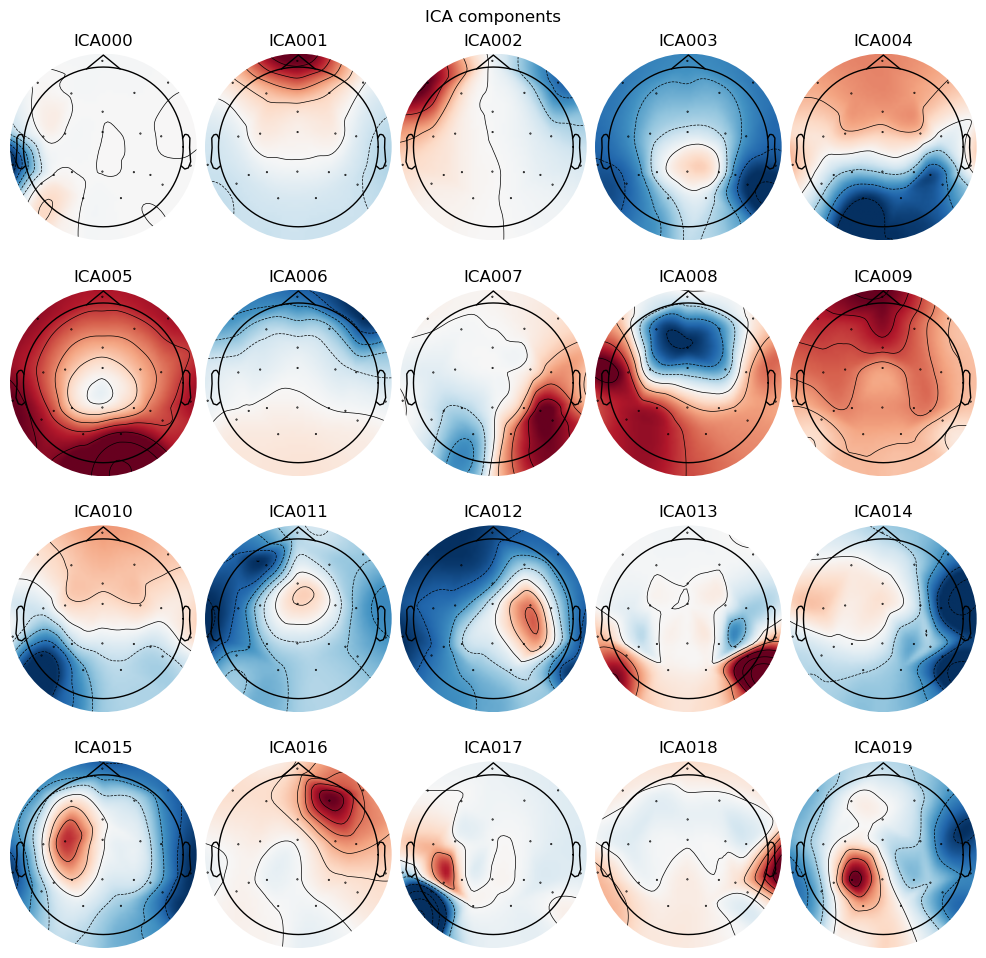

In [85]:
if visualize_ica:
    fig = ica_to_view.plot_components()

In [ ]:
# ICA component properties - helps you find artifacts
# look for
# - activity frontal channels - eye blinks
# - activity temporal channels - muscle artifacts
# - unusual frequency content


# TODO: uncomment to visualize ica component properties and change ica_music_number to desired variable
# ica_music_number.plot_properties(raw_music_number_filtered, picks=[1,2,3,8]) # change picks as needed


#### 4.3.2 Apply ICA (Remove Artifacts)

*IMPORTANT:* Before running this cell, you should:
1. Inspect the ICA components
2. Identify rtifacts
3. Set `ica.exclude`


In [88]:
icas[0].exclude = [1,3,4,6,16]  # indexes of excluded components
icas[1].exclude = [0,3,5,19]  # indexes of excluded components
icas[2].exclude = [0,3,4,5,19]  # indexes of excluded components
icas[3].exclude = [0,4,6,13,17]  # indexes of excluded components
icas[4].exclude = [1,2,13,15,17,18,19]  # indexes of excluded components
icas[5].exclude = [1,3,5,6,8,12]  # indexes of excluded components

# apply ICA
raw_classical_1_clean = icas[0].apply(raws_filtered[0].copy())
raw_classical_2_clean = icas[1].apply(raws_filtered[1].copy())
raw_classical_3_clean = icas[2].apply(raws_filtered[2].copy())
raw_rock_1_clean = icas[3].apply(raws_filtered[3].copy())
raw_rock_2_clean = icas[4].apply(raws_filtered[4].copy())
raw_rock_3_clean = icas[5].apply(raws_filtered[5].copy())

cleaned_raws = [
    raw_classical_1_clean,
    raw_classical_2_clean,
    raw_classical_3_clean,
    raw_rock_1_clean,
    raw_rock_2_clean,
    raw_rock_3_clean,
]

## 5. Visualize Cleaned Data (OPTIONAL)


*IMPORTANT*

- Set `visualize_clean_data` to True or False.
- Set `clean_to_view` to the correct raws index.

EXAMPLE: `clean_to_view = raw_classical_1_clean` *or* `clean_to_view = raws[0]` (first raw component)

In [107]:
visualize_clean_data = True # True or False
clean_to_view = cleaned_raws[0] # raw file name/index

visualize_psd_comparison =  True # True or False
raw_to_compare = raws[0] # use same index cleaned raw above

Show plot of clean data/ opens MNE.

In [102]:
if visualize_clean_data:
    clean_to_view.plot(
        duration=10.0,
        n_channels=22,
        scalings='auto',
        title='Cleaned Data',
    )
    plt.show()

Compare psd before and after cleaning


c:\Users\bicle\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


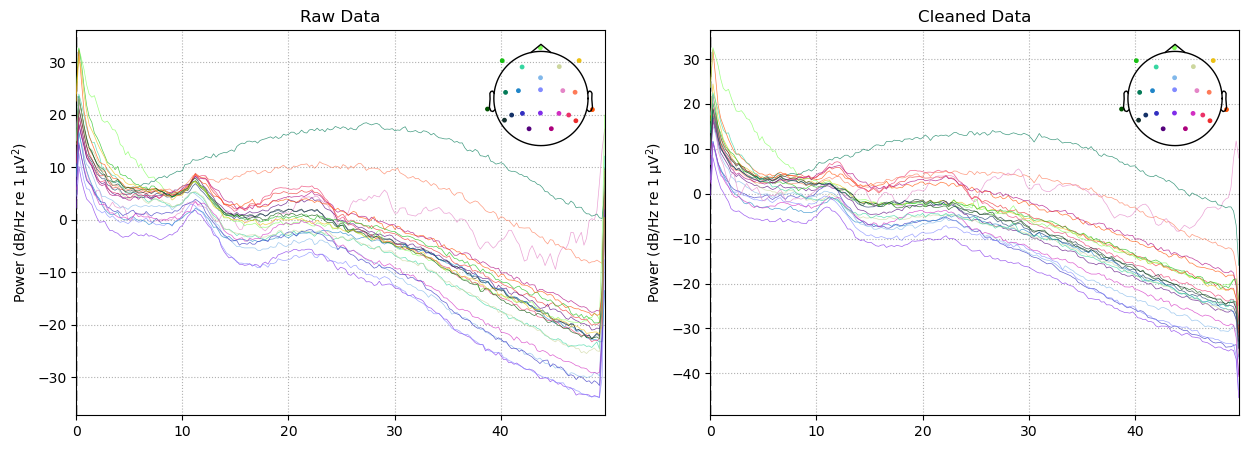

In [ ]:
if visualize_psd_comparison:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # raw data PSD
    psd_raw = raw_to_compare.compute_psd(fmax=50)
    psd_raw.plot(axes=axes[0], show=True)
    axes[0].set_title('Raw Data')

    # cleaned data PSD
    psd_clean = clean_to_view.compute_psd(fmax=50)
    psd_clean.plot(axes=axes[1], show=True)
    axes[1].set_title('Cleaned Data')

    plt.show()

In [ ]:
# post-ICA PSD: Full filtered range (1-40 Hz)

# TODO: uncomment to visualize cleaned psd and change raw_music_number to desired variable
# fig, ax = plt.subplots(figsize=(12, 8))

# psd_clean = raw_music_number_clean.compute_psd(
#     method='welch',
#     fmin=1.0, 
#     fmax=40.0, 
#     n_fft=4096, 
#     n_overlap=1024
# )

# psd_clean.plot(axes=ax, show=False, picks='eeg', average=False)
# ax.set_title('Cleaned Data PSD - Full Filtered Range (1-40 Hz)', 
#             fontsize=14, fontweight='bold')
# ax.set_xlim(1, 40)
# ax.set_ylim(-40, 20)
# ax.set_xlabel('Frequency (Hz)', fontsize=12)
# ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

# ax.grid(True, alpha=0.3, linestyle='--')
# plt.show()

In [ ]:
# post-ICA PSD: Focus on theta and alpha bands only for alpha/theta ratio analysis


# TODO: uncomment to visualize cleaned psd and change raw_music_number to desired variable
# fig, ax = plt.subplots(figsize=(12, 8))

# psd_clean = raw_music_number_clean.compute_psd(
#     method='welch',
#     fmin=3.0, 
#     fmax=15.0, 
#     n_fft=4096, 
#     n_overlap=1024
# )

# psd_clean.plot(axes=ax, show=False, picks='eeg', average=False)
# ax.set_title('Cleaned Data PSD - Theta (4-8 Hz) & Alpha (8-13 Hz) Focus', 
#             fontsize=14, fontweight='bold')
# ax.set_xlim(3, 15)
# ax.set_ylim(-20, 20)
# ax.set_xlabel('Frequency (Hz)', fontsize=12)
# ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

# ax.grid(True, alpha=0.3, linestyle='--')
# plt.show()

## 6. Epoching

Segment the continuous data into epochs based on experimental protocol phases.
s1000 marks the protocol start, and s1050 markers indicate the end of each phase.


In [ ]:
protocol_starts = []

cleaned_raws = [
    raw_classical_1_clean,
    raw_classical_2_clean,
    raw_classical_3_clean,
    raw_rock_1_clean,
    raw_rock_2_clean,
    raw_rock_3_clean,
]

for idx, raw in enumerate(cleaned_raws, start=1):
    start_time = None

    # find s1000
    for onset, description in zip(raw.annotations.onset, raw.annotations.description):
        if 's1000' in str(description):
            start_time = onset
            break

    # no s1000? find s1050
    if start_time is None:
        for onset, description in zip(raw.annotations.onset, raw.annotations.description):
            if 's1050' in str(description):
                start_time = onset
                break

    protocol_starts.append(start_time)
    print(f"Dataset {idx}: start = {start_time:.1f}s")


Dataset 1: start = 116.1s
Dataset 2: start = 7.3s
Dataset 3: start = 14.3s
Dataset 4: start = 16.2s
Dataset 5: start = 13.4s
Dataset 6: start = 77.8s


In [ ]:
base_phase_durations = [120, 120, 120, 60, 120, 60, 600]
post_task_duration = 120

datasets_with_7_phases = {1, 6}  # classical_1 and rock_3

all_phase_boundaries = {}

for idx, raw in enumerate(cleaned_raws, start=1):

    protocol_start = protocol_starts[idx - 1]

    print(f"Dataset {idx}: start = {protocol_start:.1f}s")

    current_time = protocol_start
    recording_end = raw.times[-1]
    phase_boundaries = {}

    for i, duration in enumerate(base_phase_durations, start=1):
        phase_name = f"phase_{i}"
        phase_start = current_time
        phase_end = min(current_time + duration, recording_end)
        phase_boundaries[phase_name] = (phase_start, phase_end)
        current_time = phase_end

    if idx not in datasets_with_7_phases:
        phase_start = current_time
        phase_end = min(current_time + post_task_duration, recording_end)
        phase_boundaries["phase_8"] = (phase_start, phase_end)

    all_phase_boundaries[idx] = phase_boundaries

    print(f"\nDataset {idx} phases")
    for phase, (start, end) in phase_boundaries.items():
        dur = end - start
        print(f"  {phase}: {start:.1f}s – {end:.1f}s ({dur/60:.1f} min)")


Dataset 1: start = 116.1s

Dataset 1 phases
  phase_1: 116.1s – 236.1s (2.0 min)
  phase_2: 236.1s – 356.1s (2.0 min)
  phase_3: 356.1s – 476.1s (2.0 min)
  phase_4: 476.1s – 536.1s (1.0 min)
  phase_5: 536.1s – 656.1s (2.0 min)
  phase_6: 656.1s – 716.1s (1.0 min)
  phase_7: 716.1s – 1302.0s (9.8 min)
Dataset 2: start = 7.3s

Dataset 2 phases
  phase_1: 7.3s – 127.3s (2.0 min)
  phase_2: 127.3s – 247.3s (2.0 min)
  phase_3: 247.3s – 367.3s (2.0 min)
  phase_4: 367.3s – 427.3s (1.0 min)
  phase_5: 427.3s – 547.3s (2.0 min)
  phase_6: 547.3s – 607.3s (1.0 min)
  phase_7: 607.3s – 1207.3s (10.0 min)
  phase_8: 1207.3s – 1327.3s (2.0 min)
Dataset 3: start = 14.3s

Dataset 3 phases
  phase_1: 14.3s – 134.3s (2.0 min)
  phase_2: 134.3s – 254.3s (2.0 min)
  phase_3: 254.3s – 374.3s (2.0 min)
  phase_4: 374.3s – 434.3s (1.0 min)
  phase_5: 434.3s – 554.3s (2.0 min)
  phase_6: 554.3s – 614.3s (1.0 min)
  phase_7: 614.3s – 1214.3s (10.0 min)
  phase_8: 1214.3s – 1334.3s (2.0 min)
Dataset 4: sta

In [ ]:
epoch_duration = 30.0
epoch_overlap = 0.0
all_epochs_per_dataset = {}

for idx, raw in enumerate(cleaned_raws, start=1):
    phase_boundaries = all_phase_boundaries[idx]
    all_epochs_list = []
    all_metadata_list = []

    with mne.utils.use_log_level('ERROR'):
        for phase_name, (start, end) in phase_boundaries.items():
            phase_start = max(0.0, start)
            phase_end = min(end, raw.times[-1])
            phase_length = phase_end - phase_start
            if phase_length <= 0:
                continue

            raw_phase = raw.copy().crop(tmin=phase_start, tmax=phase_end)
            epochs_phase = mne.make_fixed_length_epochs(
                raw_phase,
                duration=epoch_duration,
                overlap=epoch_overlap,
                preload=True
            )

            n_epochs = len(epochs_phase)
            phase_metadata = pd.DataFrame({
                'phase': [phase_name] * n_epochs,
                'epoch_in_phase': range(n_epochs)
            })
            epochs_phase.metadata = phase_metadata

            all_epochs_list.append(epochs_phase)
            all_metadata_list.append(phase_metadata)

    if len(all_epochs_list) > 0:
        with mne.utils.use_log_level('ERROR'):
            combined_epochs = mne.concatenate_epochs(all_epochs_list)
        combined_epochs.metadata = pd.concat(all_metadata_list, ignore_index=True)
        all_epochs_per_dataset[idx] = combined_epochs

        # Print concise summary
        total_epochs = len(combined_epochs)
        phase_counts = combined_epochs.metadata['phase'].value_counts().to_dict()
        print(f"Dataset {idx}: {total_epochs} epochs → {phase_counts}")
    else:
        print(f"Dataset {idx}: No epochs created")


Replacing existing metadata with 2 columns
Dataset 1: 39 epochs → {'phase_7': 19, 'phase_2': 4, 'phase_1': 4, 'phase_3': 4, 'phase_5': 4, 'phase_4': 2, 'phase_6': 2}
Replacing existing metadata with 2 columns
Dataset 2: 44 epochs → {'phase_7': 20, 'phase_1': 4, 'phase_3': 4, 'phase_2': 4, 'phase_8': 4, 'phase_5': 4, 'phase_4': 2, 'phase_6': 2}
Replacing existing metadata with 2 columns
Dataset 3: 44 epochs → {'phase_7': 20, 'phase_1': 4, 'phase_3': 4, 'phase_2': 4, 'phase_8': 4, 'phase_5': 4, 'phase_4': 2, 'phase_6': 2}
Replacing existing metadata with 2 columns
Dataset 4: 44 epochs → {'phase_7': 20, 'phase_1': 4, 'phase_3': 4, 'phase_2': 4, 'phase_8': 4, 'phase_5': 4, 'phase_4': 2, 'phase_6': 2}
Replacing existing metadata with 2 columns
Dataset 5: 44 epochs → {'phase_7': 20, 'phase_1': 4, 'phase_3': 4, 'phase_2': 4, 'phase_8': 4, 'phase_5': 4, 'phase_4': 2, 'phase_6': 2}
Replacing existing metadata with 2 columns
Dataset 6: 40 epochs → {'phase_7': 20, 'phase_2': 4, 'phase_1': 4, 'pha

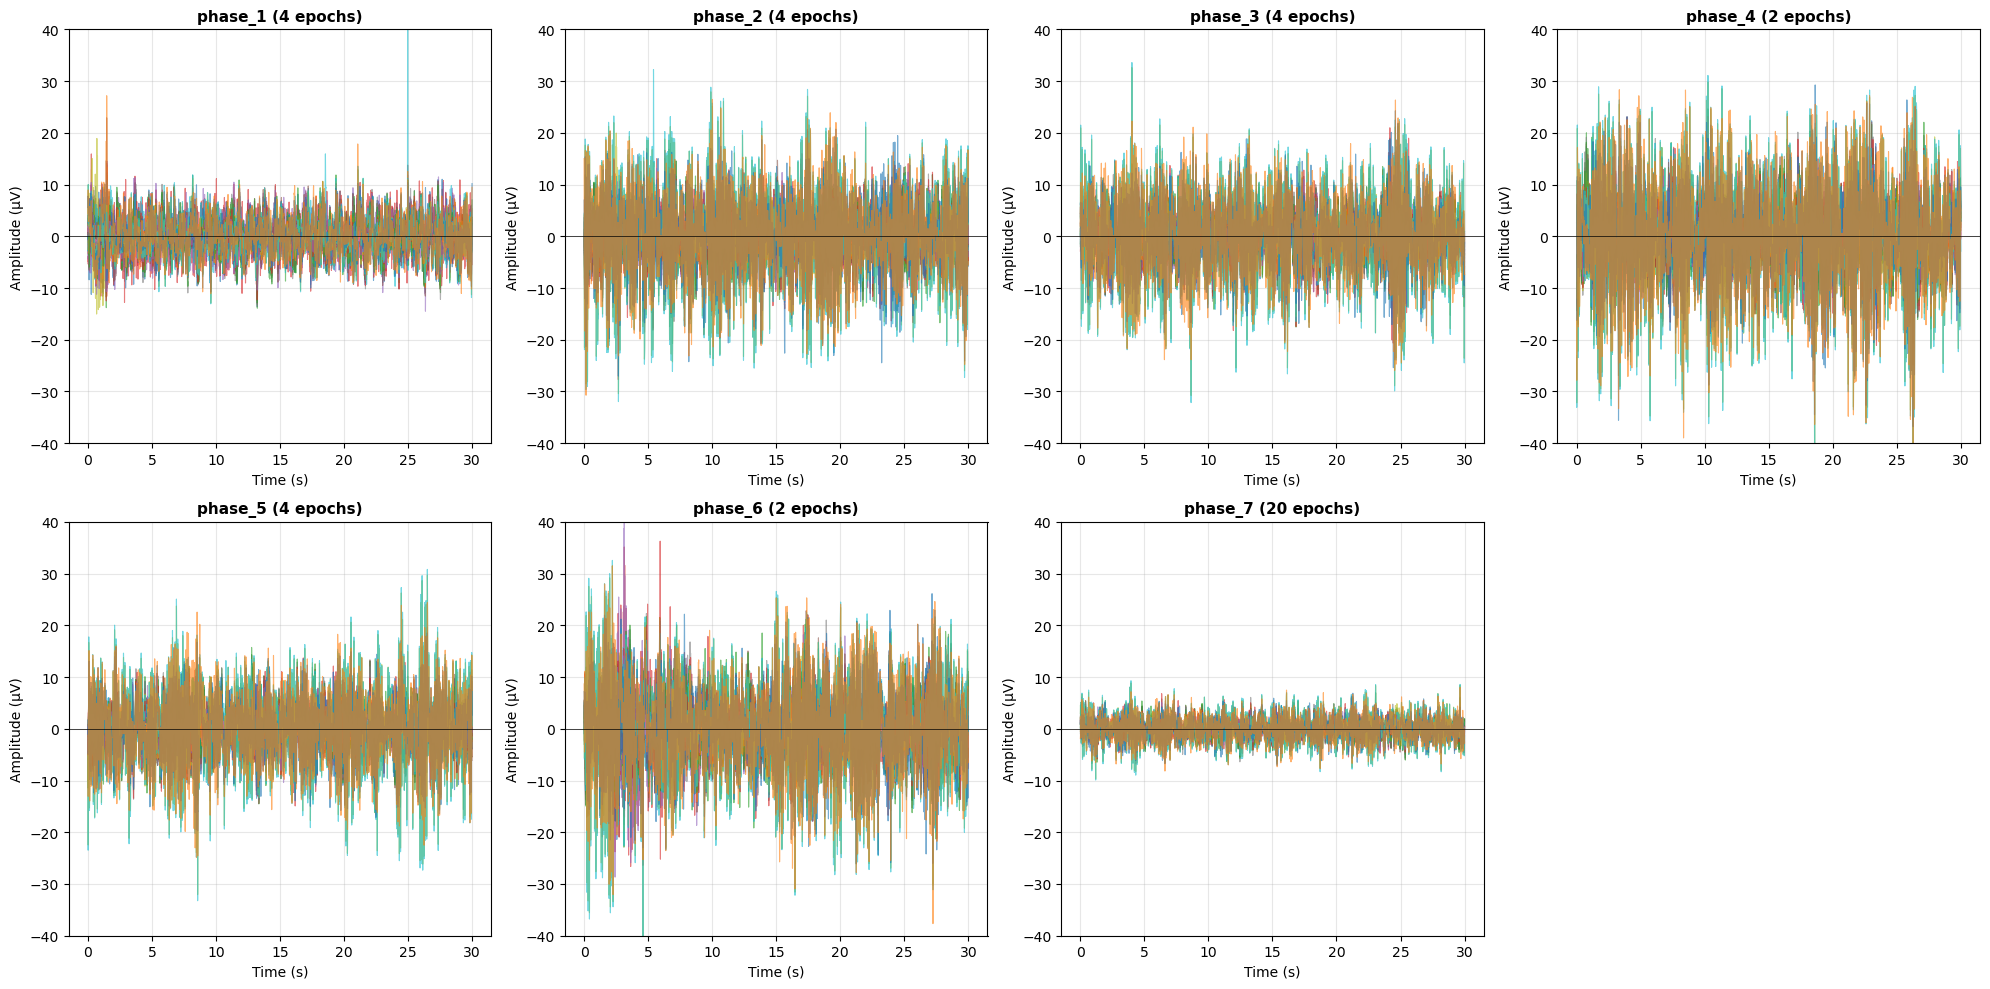

In [ ]:
import matplotlib.pyplot as plt

#TODO: choose dataset no.
dataset_idx = 6
epochs_all = all_epochs_per_dataset[dataset_idx]

phase_names = epochs_all.metadata['phase'].unique()
n_phases = len(phase_names)
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

# choose how much you see of Y amplitude
ymin, ymax = -40, 40  

for idx, phase_name in enumerate(phase_names):
    epochs_phase = epochs_all[epochs_all.metadata['phase'] == phase_name]
    evoked = epochs_phase.average()
    data = evoked.get_data() * 1e6  
    times = evoked.times
    
    for ch_data in data:
        axes[idx].plot(times, ch_data, alpha=0.6, linewidth=0.8)
    
    axes[idx].set_title(f"{phase_name} ({len(epochs_phase)} epochs)", fontsize=11, fontweight='bold')
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Amplitude (µV)")
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(0, color='black', linewidth=0.5)
    axes[idx].set_ylim(ymin, ymax)  

for idx in range(n_phases, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Create epochs_by_phase and labeled_phases dictionaries
# Map phase numbers to descriptive phase names
phase_name_mapping = {
    'phase_1': 'baseline_EO',
    'phase_2': 'baseline_EC',
    'phase_3': 'task_no_music',
    'phase_4': 'break1',
    'phase_5': 'task_music',
    'phase_6': 'break2',
    'phase_7': 'meditation',
    'phase_8': 'post_EC'
}

# Get phase boundaries for the selected dataset
phase_boundaries = all_phase_boundaries[dataset_idx]

# Create epochs_by_phase: dictionary mapping phase names to epoch objects
epochs_by_phase = {}
for phase_num in epochs_all.metadata['phase'].unique():
    phase_label = phase_name_mapping.get(phase_num, phase_num)  # Use mapped name or fallback to original
    epochs_by_phase[phase_label] = epochs_all[epochs_all.metadata['phase'] == phase_num]

# Create labeled_phases: dictionary mapping phase names to (start, end) time tuples
labeled_phases = {}
for phase_num, (start, end) in phase_boundaries.items():
    phase_label = phase_name_mapping.get(phase_num, phase_num)  # Use mapped name or fallback to original
    labeled_phases[phase_label] = (start, end)

print(f"Created epochs_by_phase with {len(epochs_by_phase)} phases:")
for phase_name, epochs_phase in epochs_by_phase.items():
    print(f"  {phase_name}: {len(epochs_phase)} epochs")

Created epochs_by_phase with 7 phases:
  baseline_EO: 4 epochs
  baseline_EC: 4 epochs
  task_no_music: 4 epochs
  break1: 2 epochs
  task_music: 4 epochs
  break2: 2 epochs
  meditation: 20 epochs


## Observations 
- Meditation phase stands out:
    - Much lower amplitudes (-4 to 3 µV) vs others (-10 to 20 µV)
    - More stable signal
    - 315 epochs (longest phase)
- Consistent with a relaxed/meditative state
    - Task phases show higher activity:
    - task_no_music: highest amplitudes (-20 to 20 µV)
    - task_music: moderate amplitudes (-15 to 15 µV)
    - Expected during active tasks
- Baseline phases:
    - baseline_EO and baseline_EC: moderate amplitudes
    - baseline_EC slightly higher than baseline_EO (typical)
- Break phases:
    - Lower amplitudes, more stable
    - Consistent with rest periods

In [ ]:
# Summary table of epochs by phase
comprehensive_data = []

for phase_name, epochs_phase in epochs_by_phase.items():
    if len(epochs_phase) > 0:
        data = epochs_phase.get_data()
        phase_start, phase_end = labeled_phases[phase_name]
        
        # Overall statistics
        max_amp = np.abs(data).max() * 1e6
        mean_amp = np.abs(data).mean() * 1e6
        std_amp = data.std() * 1e6
        
        # Per-channel average
        channel_means = np.abs(data).mean(axis=(0, 2)) * 1e6
        max_channel_amp = channel_means.max()
        min_channel_amp = channel_means.min()
        mean_channel_amp = channel_means.mean()
        
        comprehensive_data.append({
            'Phase': phase_name,
            'N_Epochs': len(epochs_phase),
            'Start_s': phase_start,
            'End_s': phase_end,
            'Duration_s': phase_end - phase_start,
            'Duration_min': (phase_end - phase_start) / 60,
            'Max_Amp_µV': max_amp,
            'Mean_Amp_µV': mean_amp,
            'Std_Amp_µV': std_amp,
            'Max_Channel_Mean_µV': max_channel_amp,
            'Min_Channel_Mean_µV': min_channel_amp,
            'Mean_Channel_Mean_µV': mean_channel_amp
        })

comprehensive_df = pd.DataFrame(comprehensive_data)
comprehensive_df

,Phase,N_Epochs,Start_s,End_s,Duration_s,Duration_min,Max_Amp_µV,Mean_Amp_µV,Std_Amp_µV,Max_Channel_Mean_µV,Min_Channel_Mean_µV,Mean_Channel_Mean_µV
0,baseline_EO,4,77.766,197.766,120.0,2.0,195.687061,4.372854,5.886569,5.646955,1.636321,4.372854
1,baseline_EC,4,197.766,317.766,120.0,2.0,123.755336,7.373558,10.280968,15.651386,2.501639,7.373558
2,task_no_music,4,317.766,437.766,120.0,2.0,58.847577,6.521899,9.039016,13.453029,2.335300,6.521899
3,break1,2,437.766,497.766,60.0,1.0,58.521935,6.405204,8.846837,12.944008,2.378482,6.405204
4,task_music,4,497.766,617.766,120.0,2.0,66.414542,6.246507,8.712815,12.875202,2.261034,6.246507
5,break2,2,617.766,677.766,60.0,1.0,87.338551,5.777008,8.088771,10.666758,2.118571,5.777008
6,meditation,20,677.766,1277.766,600.0,10.0,109.953139,5.298572,7.369391,9.576650,1.958170,5.298572


## 7. Power Analysis (Alpha & Theta)

### Extract power in alpha (8-13 Hz) and theta (4-8 Hz) frequency bands and compare between experimental phases (baseline, meditation, post-meditation)

In [ ]:
# Compute PSD for each experimental phase
psd_by_phase = {}

for phase_name, epochs_phase in epochs_by_phase.items():
    print(f"Computing PSD for {phase_name}...")
    psd_by_phase[phase_name] = epochs_phase.compute_psd(
        method='welch',
        fmin=1.0,
        fmax=40.0
    )
    print(f"  ✓ {phase_name}: {len(epochs_phase)} epochs, {len(psd_by_phase[phase_name].ch_names)} channels")

Computing PSD for baseline_EO...
Effective window size : 4.096 (s)
  ✓ baseline_EO: 4 epochs, 22 channels
Computing PSD for baseline_EC...
Effective window size : 4.096 (s)
  ✓ baseline_EC: 4 epochs, 22 channels
Computing PSD for task_no_music...
Effective window size : 4.096 (s)
  ✓ task_no_music: 4 epochs, 22 channels
Computing PSD for break1...
Effective window size : 4.096 (s)
  ✓ break1: 2 epochs, 22 channels
Computing PSD for task_music...
Effective window size : 4.096 (s)
  ✓ task_music: 4 epochs, 22 channels
Computing PSD for break2...
Effective window size : 4.096 (s)
  ✓ break2: 2 epochs, 22 channels
Computing PSD for meditation...
Effective window size : 4.096 (s)
  ✓ meditation: 20 epochs, 22 channels


In [ ]:
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
}

phase_power_results = {}

for phase_name, psd_phase in psd_by_phase.items():
    psd_data = psd_phase.get_data()  # shape: (n_epochs, n_channels, n_freqs)
    freqs = psd_phase.freqs         # shape: (n_freqs,)
    
    results = {}
    for band_name, (fmin_band, fmax_band) in freq_bands.items():
        # Select frequency indices
        freq_mask = (freqs >= fmin_band) & (freqs <= fmax_band)
        # Average over selected frequencies and epochs
        band_power = psd_data[:, :, freq_mask].mean(axis=2).mean(axis=0)  # mean over epochs & freqs
        results[band_name] = band_power * 1e12  # V²/Hz → µV²/Hz
    
    # Alpha/Theta ratio
    results['alpha_theta_ratio'] = results['alpha'] / results['theta']
    results['channels'] = psd_phase.ch_names
    
    phase_power_results[phase_name] = results
    
    # Print summary for dataset & phase
    print(f"\nDataset {dataset_idx} — {phase_name}:")
    print(f"  Mean Theta Power: {results['theta'].mean():.4f} µV²/Hz")
    print(f"  Mean Alpha Power: {results['alpha'].mean():.4f} µV²/Hz")
    print(f"  Mean Alpha/Theta Ratio: {results['alpha_theta_ratio'].mean():.4f}")



baseline_EO:
  Mean Theta Power: 1.4750 µV²/Hz
  Mean Alpha Power: 0.6602 µV²/Hz
  Mean Alpha/Theta Ratio: 0.4459

baseline_EC:
  Mean Theta Power: 3.5300 µV²/Hz
  Mean Alpha Power: 13.5172 µV²/Hz
  Mean Alpha/Theta Ratio: 3.3876

task_no_music:
  Mean Theta Power: 1.9309 µV²/Hz
  Mean Alpha Power: 9.2200 µV²/Hz
  Mean Alpha/Theta Ratio: 4.0311

break1:
  Mean Theta Power: 2.2431 µV²/Hz
  Mean Alpha Power: 10.7267 µV²/Hz
  Mean Alpha/Theta Ratio: 4.1329

task_music:
  Mean Theta Power: 1.7612 µV²/Hz
  Mean Alpha Power: 9.2886 µV²/Hz
  Mean Alpha/Theta Ratio: 4.5423

break2:
  Mean Theta Power: 1.6384 µV²/Hz
  Mean Alpha Power: 7.2538 µV²/Hz
  Mean Alpha/Theta Ratio: 4.0246

meditation:
  Mean Theta Power: 1.6274 µV²/Hz
  Mean Alpha Power: 5.5504 µV²/Hz
  Mean Alpha/Theta Ratio: 3.1183


In [ ]:
results = []
for phase_name, power_data in phase_power_results.items():
    for ch_idx, ch_name in enumerate(power_data['channels']):
        results.append({
            'Phase': phase_name,
            'Channel': ch_name,
            'Theta_Power_µV²': power_data['theta'][ch_idx],
            'Alpha_Power_µV²': power_data['alpha'][ch_idx],
            'Alpha_Theta_Ratio': power_data['alpha_theta_ratio'][ch_idx]
        })

power_analysis_df = pd.DataFrame(results)
power_analysis_df  

,Phase,Channel,Theta_Power_µV²,Alpha_Power_µV²,Alpha_Theta_Ratio
0,baseline_EO,FPz,1.583709,0.583798,0.368627
1,baseline_EO,FCz,0.750321,0.285316,0.380259
2,baseline_EO,F9,1.601818,0.589558,0.368055
3,baseline_EO,F3,1.262211,0.794873,0.629747
4,baseline_EO,F4,1.500589,0.693205,0.461956
...,...,...,...,...,...
149,meditation,P4,0.633862,3.693212,5.826526
150,meditation,P8,3.499145,19.654198,5.616858
151,meditation,P10,3.837292,21.383570,5.572568
152,meditation,O1,2.275013,13.075792,5.747568


In [ ]:
# Summary statistics by phase
summary = power_analysis_df.groupby('Phase').agg({
    'Theta_Power_µV²': ['mean', 'std'],
    'Alpha_Power_µV²': ['mean', 'std'],
    'Alpha_Theta_Ratio': ['mean', 'std']
})
print("\n=== Summary Statistics by Phase ===")
print(summary)



=== Summary Statistics by Phase ===
              Theta_Power_µV²           Alpha_Power_µV²             \
                         mean       std            mean        std   
Phase                                                                
baseline_EC          3.529953  3.401874       13.517166  16.232179   
baseline_EO          1.475001  0.832142        0.660176   0.391347   
break1               2.243150  1.699664       10.726679  13.503641   
break2               1.638376  1.110237        7.253847   8.775170   
meditation           1.627448  1.052994        5.550434   6.571820   
task_music           1.761213  1.313842        9.288606  11.335204   
task_no_music        1.930919  1.540387        9.220029  11.220965   

              Alpha_Theta_Ratio            
                           mean       std  
Phase                                      
baseline_EC            3.387588  1.143870  
baseline_EO            0.445936  0.073015  
break1                 4.132924  2.380738 